# Machine Learning Project  
We start by importing the necessary features and the set of data. We take 80% as the size of the set.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
%matplotlib inline

#read and randomly shuffle data
wines = pd.read_csv('winequality.csv', sep=';').as_matrix()
wines = wines[np.random.permutation(wines.shape[0]),:]
tr_set_size = np.int(len(wines)*0.8)

#assign train and test sets (in your experiments, you want to do cross-validation)
X_tr = wines[0:tr_set_size,0:-1]
y_tr = wines[0:tr_set_size,-1]
X_test = wines[tr_set_size:,0:-1]
y_test = wines[tr_set_size:,-1]


# K Nearest Neighbours Algorithm  
We'll first start with the K Nearest Neighbours algorithm  

We will try it first for 5 neighbours.


In [2]:
# importing the needed libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
#
knn = KNeighborsClassifier(n_neighbors=5)

# We first have to fit the model
knn.fit(X_tr, y_tr)

# predict the response
pred = knn.predict(X_test)

# evaluating the accuracy

print(accuracy_score(y_test, pred))


0.473076923077


### Best numbers of neighbours
We wrote a function to see what the best number of neighbours would be.

In [3]:
rows = wines.shape[0]

def findBestN(X_tr, y_tr, y_test):
    best_N = 1
    best_acc = 0
    
    results = []
    
    N = 1
    while (N < 100):
        knn = KNeighborsClassifier(n_neighbors=N)
        knn.fit(X_tr, y_tr)
        pred = knn.predict(X_test)
        accuracy = accuracy_score(y_test, pred)
        if (best_acc < accuracy):
            best_acc = accuracy
            best_N = N
        N = N + 1
    print("The best number of neighbours is %d" % best_N)
    print("With the best accuracy of %.20f" % best_acc)
    
findBestN(X_tr, y_tr, y_test)

        

The best number of neighbours is 1
With the best accuracy of 0.57615384615384612754


### Cross Validation
Then we do the cross validation. We split our classes in parts and then check the crossvalidation.  
We will do a 10-fold cross validation. We will compare the different numbers of neighbours using the mean squared error. We will also compute the 95% confidence interval.

In [4]:
from sklearn.model_selection import cross_val_score, KFold, train_test_split
%matplotlib inline

num_folds=10
kf = KFold(n_splits=num_folds, shuffle=True)
print(kf)
cross_validation_scores = []
K = 1

while K < num_folds :
    knn = KNeighborsClassifier(n_neighbors=K)
    scores = cross_val_score(knn, X_tr, y_tr, cv=kf, scoring='neg_mean_squared_error')
    cross_validation_scores.append(scores.mean())
    K+=1

delta_mean = np.mean(cross_validation_scores)
print("mean error difference:" +repr(delta_mean))

sdelta = np.std(cross_validation_scores)
print("error stdev estimate:" +repr(sdelta))
print("CI interval: [" +repr(delta_mean- 2.23* sdelta)
              +","+repr(delta_mean+ 2.23* sdelta) +"]")

KFold(n_splits=10, random_state=None, shuffle=True)
mean error difference:-0.91551047379082062
error stdev estimate:0.055025400728933652
CI interval: [-1.0382171174163426,-0.79280383016529854]


### Diagnosing high bias  
The next step was diagnosing if there was a high bias. We did this first for 1 neighbor then for 10 to give some different views. We did this with the learning curves.

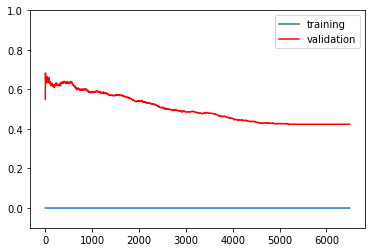

In [5]:
num_samples = np.arange(1,len(y_tr)+len(y_test))

train_score = np.zeros(len(num_samples))
val_score = np.zeros(len(num_samples))

for idx,samples in enumerate(num_samples):
            model = KNeighborsClassifier(n_neighbors=1)
            model.fit(X_tr[0:samples,:],y_tr[0:samples])
            train_score[idx] = model.score(X_tr[0:samples,:],y_tr[0:samples])
            val_score[idx] = model.score(X_test,y_test)

 #plot learning curves
pl.figure()
pl.ylim((-0.1,1))
#error rate = 1.0 - accurracy 
pl.plot(num_samples,1.0-train_score,label='training') 
pl.plot(num_samples,1.0-val_score,'r',label='validation') 
pl.legend()

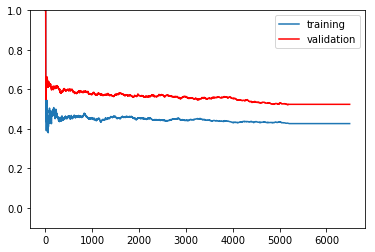

In [6]:
train_score = np.zeros(len(num_samples))
val_score = np.zeros(len(num_samples))

for idx,samples in enumerate(num_samples):
    if (samples > 10):
            model = KNeighborsClassifier(n_neighbors=10)
            model.fit(X_tr[0:samples,:],y_tr[0:samples])
            train_score[idx] = model.score(X_tr[0:samples,:],y_tr[0:samples])
            val_score[idx] = model.score(X_test,y_test)

 #plot learning curves
pl.figure()
pl.ylim((-0.1,1))
#error rate = 1.0 - accurracy 
pl.plot(num_samples,1.0-train_score,label='training') 
pl.plot(num_samples,1.0-val_score,'r',label='validation') 
pl.legend()

The second example shows that both curves are close to each other. The training curve is however quite high, which shows that it suffers from high bias. we als see that the second exam-ple suffers from a high variance. The training curve will be low and the validation set will be high and bot will be very close.

### Check for hidden parameters

In [20]:
from sklearn import metrics

max_d = np.arange(1,200)

train_score = np.zeros(len(max_d))
val_score = np.zeros(len(max_d))

for idx,neighbors in enumerate(max_d):
    model = KNeighborsClassifier(n_neighbors = neighbors)
    model.fit(X_tr,y_tr)
    train_score[idx] = model.score(X_tr,y_tr)
    val_score[idx] = model.score(X_test,y_test)
    
pl.figure()
pl.plot(max_d,1.0-train_score,label='training')
pl.plot(max_d,1.0-val_score,'r',label='validation')
pl.legend()

Like with the earlier tests we find that the best results are with only 1 neigbour. However the training and validate curve come closer together with more neighbors. We can also see that with more than 175 our trainig curve is nearly as bad as the validation curve.

# Decision Tree
For the second exmperiment we have chosen the decision tree. We will first try it for some different depths. We will also create a confusion matrix. This gives us a good visual idea over the errors our model makes.

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

#create a tree model which uses entropy to select splitting features
tree = DecisionTreeClassifier(criterion='entropy',max_depth=1)

#train the decision tree on our training set 
tree=tree.fit(X_tr,y_tr)

#use trained model to make predictions on test data 
predictions=tree.predict(X_test)
#use the score function to determine classification accuracy (percentage correctly classified) 
print('classification accuracy: ' +repr(tree.score(X_test,y_test)))


#get confusion matrix
cm = confusion_matrix(y_test, predictions) #display matrix
print(cm)
# plot confusion matrix
pl.matshow(cm)
pl.title('Confusion matrix')
pl.colorbar()
pl.ylabel('True class label')
pl.xlabel('Predicted class label')
pl.show()


classification accuracy: 0.47076923076923077
[[  0   0   4   4   0   0   0]
 [  0   0  24  17   0   0   0]
 [  0   0 349  69   0   0   0]
 [  0   0 321 263   0   0   0]
 [  0   0  48 155   0   0   0]
 [  0   0  10  34   0   0   0]
 [  0   0   0   2   0   0   0]]


In [9]:
#create a tree model which uses entropy to select splitting features
tree = DecisionTreeClassifier(criterion='entropy',max_depth=10)

#train the decision tree on our training set 
tree=tree.fit(X_tr,y_tr)

#use trained model to make predictions on test data 
predictions=tree.predict(X_test)
#use the score function to determine classification accuracy (percentage correctly classified) 
print('classification accuracy: ' +repr(tree.score(X_test,y_test)))

#get confusion matrix
cm = confusion_matrix(y_test, predictions) #display matrix
print(cm)
# plot confusion matrix
pl.matshow(cm)
pl.title('Confusion matrix')
pl.colorbar()
pl.ylabel('True class label')
pl.xlabel('Predicted class label')
pl.show()


classification accuracy: 0.53692307692307695
[[  0   2   4   1   0   1   0]
 [  1   5  22  12   1   0   0]
 [  0   9 264 133  11   1   0]
 [  4   5 149 337  88   1   0]
 [  0   1  13 101  85   3   0]
 [  0   0   2  21  14   7   0]
 [  0   0   0   0   2   0   0]]


classification accuracy: 0.60153846153846158
[[  0   2   5   0   0   1   0]
 [  1   8  15  13   4   0   0]
 [  1  10 270 118  14   5   0]
 [  4  12  94 369  92  13   0]
 [  1   1  14  62 116   9   0]
 [  0   1   2  14   8  19   0]
 [  0   0   0   0   0   2   0]]


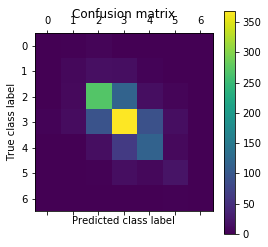

In [10]:
#create a tree model which uses entropy to select splitting features
tree = DecisionTreeClassifier(criterion='entropy',max_depth=50)

#train the decision tree on our training set 
tree=tree.fit(X_tr,y_tr)

#use trained model to make predictions on test data 
predictions=tree.predict(X_test)
#use the score function to determine classification accuracy (percentage correctly classified) 
print('classification accuracy: ' +repr(tree.score(X_test,y_test)))

#get confusion matrix
cm = confusion_matrix(y_test, predictions) #display matrix
print(cm)
# plot confusion matrix
pl.matshow(cm)
pl.title('Confusion matrix')
pl.colorbar()
pl.ylabel('True class label')
pl.xlabel('Predicted class label')
pl.show()


### Cross Validation
Then we do the cross validation. We split our classes in parts and then check the crossvalidation.  
We will do a 10-fold cross validation. We will compare the different depths using the mean squared error. We will also compute the 95% confidence interval.

In [17]:
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn import tree
%matplotlib inline

num_folds=10
kf = KFold(n_splits=num_folds, shuffle=True)
print(kf)
cross_validation_scores = []
d = 1

while d < num_folds :
    tr = tree.DecisionTreeRegressor(max_depth=d)
    scores = cross_val_score(tr, X_tr, y_tr, cv=kf, scoring='neg_mean_squared_error')
    cross_validation_scores.append(scores.mean())
    d+=1

delta_mean = np.mean(cross_validation_scores)
print("mean error difference:" +repr(delta_mean))

sdelta = np.std(cross_validation_scores)
print("error stdev estimate:" +repr(sdelta))
print("CI interval: [" +repr(delta_mean- 2.23* sdelta)
              +","+repr(delta_mean+ 2.23* sdelta) +"]")

KFold(n_splits=10, random_state=None, shuffle=True)
mean error difference:-0.57221513078854924
error stdev estimate:0.02886274558934086
CI interval: [-0.63657905345277932,-0.50785120812431916]


### Diagnosing high bias  
The next step was diagnosing if there was a high bias. We did this first for depth 1 then for 10 to give some different views. We did this with the learning curves.

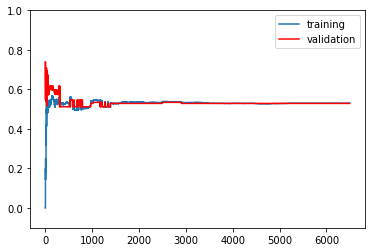

In [18]:
num_samples = np.arange(1,len(y_tr)+len(y_test))

train_score = np.zeros(len(num_samples))
val_score = np.zeros(len(num_samples))

for idx,samples in enumerate(num_samples):
            model = DecisionTreeClassifier(criterion='entropy',max_depth=1)
            model.fit(X_tr[0:samples,:],y_tr[0:samples])
            train_score[idx] = model.score(X_tr[0:samples,:],y_tr[0:samples])
            val_score[idx] = model.score(X_test,y_test)

 #plot learning curves
pl.figure()
pl.ylim((-0.1,1))
#error rate = 1.0 - accurracy 
pl.plot(num_samples,1.0-train_score,label='training') 
pl.plot(num_samples,1.0-val_score,'r',label='validation') 
pl.legend()

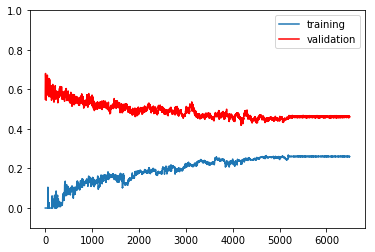

In [21]:
num_samples = np.arange(1,len(y_tr)+len(y_test))

train_score = np.zeros(len(num_samples))
val_score = np.zeros(len(num_samples))

for idx,samples in enumerate(num_samples):
            model = DecisionTreeClassifier(criterion='entropy',max_depth=10)
            model.fit(X_tr[0:samples,:],y_tr[0:samples])
            train_score[idx] = model.score(X_tr[0:samples,:],y_tr[0:samples])
            val_score[idx] = model.score(X_test,y_test)

 #plot learning curves
pl.figure()
pl.ylim((-0.1,1))
#error rate = 1.0 - accurracy 
pl.plot(num_samples,1.0-train_score,label='training') 
pl.plot(num_samples,1.0-val_score,'r',label='validation') 
pl.legend()

The first example shows that both curves are close to each other. The training curve is however quite high, which shows that it suffers from high bias. We als see that the first example suffers from a high variance. The training curve will be low and the validation set will be high and bot will be very close. This is how ever also true for the second example but less extreme.

### Check for hidden parameters

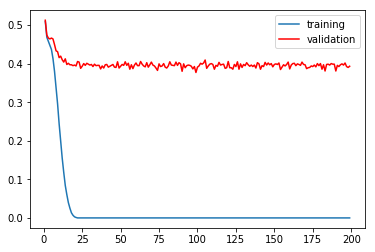

In [24]:
from sklearn import metrics

max_d = np.arange(1,200)

train_score = np.zeros(len(max_d))
val_score = np.zeros(len(max_d))

for idx,depth in enumerate(max_d):
    model = tree.DecisionTreeClassifier(max_depth = depth)
    model.fit(X_tr,y_tr)
    train_score[idx] = model.score(X_tr,y_tr)
    val_score[idx] = model.score(X_test,y_test)
    
pl.figure()
pl.plot(max_d,1.0-train_score,label='training')
pl.plot(max_d,1.0-val_score,'r',label='validation')
pl.legend()

We see that with more depth our training set will go to zero between 20 and 25. For our validation data it goes down to it lowest point around 25 afterwards it does not change that much anymore.